# McCell Model Data Streaming From Disk

Model the CellxGene Census data by streaming the data from disk, to save on memory issues. Based on the tutorial from https://chanzuckerberg.github.io/cellxgene-census/notebooks/experimental/pytorch.html

Need to run ```mccell_preprocess_from_disk.ipynb``` first, which saves some preprocessing files this program loads and uses. 


In [1]:
import cellxgene_census
import cellxgene_census.experimental.ml as census_ml
import tiledbsoma as soma

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from torcheval.metrics.functional import multilabel_accuracy

from sklearn.metrics import f1_score


import pandas as pd
import numpy as np

import os
import time
import copy
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Plotting Function

In [3]:
def plot_results(marginalization_dict,num_epochs,save_title=None):
    fig, ax = plt.subplots(4,2,figsize=(9,12))
    
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_leaf_hist'], 
                    ax = ax[0,0],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_leaf_hist'], 
                    ax = ax[0,0],color='mediumslateblue',label='Validation')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_internal_hist'],
                   ax = ax[0,1],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_internal_hist'],
                   ax = ax[0,1],color='mediumslateblue',label='Validation')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_hist'], 
                    ax = ax[1,0],color='lightcoral')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_hist'], 
                    ax = ax[1,0],color='mediumslateblue')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_leaf_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='X',label='Train Leafs')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='o',label='Train Internal')
    #sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
    #                ax = ax[1,0],color='lightcoral',marker='v',label='Train Internal')

    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_leaf_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='X',label='Val Leafs')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='o',label='Val Internal')
    #sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
    #                ax = ax[1,1],color='mediumslateblue',marker='v',label='Val Internal')


    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_leaf'], 
                    ax = ax[2,1],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_leaf'], 
                    ax = ax[2,1],color='mediumslateblue',label='Validation')

    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_internal'], 
                    ax = ax[3,0],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_internal'], 
                    ax = ax[3,0],color='mediumslateblue',label='Validation')

    
    ax[0,0].set_xlabel('Epoch')
    ax[0,1].set_xlabel('Epoch')
    ax[1,0].set_xlabel('Epoch')
    ax[1,1].set_xlabel('Epoch')
    ax[2,0].set_xlabel('Epoch')
    ax[2,1].set_xlabel('Epoch')
    ax[3,0].set_xlabel('Epoch')


    ax[0,0].set_ylabel('Leaf Accuracy')
    ax[0,1].set_ylabel('Internal Accuracy')
    ax[1,0].set_ylabel('Total Loss')
    ax[1,1].set_ylabel('Training Loss')
    ax[2,0].set_ylabel('Validation Loss')
    ax[2,1].set_ylabel('Leaf F1 Score')
    ax[3,0].set_ylabel('Internal F1 Score')


    # set the boundary for the accuracy plots
    #ax[0,1].set_ylim((50,100))
    
    # turn off the axis for subplot 2,1
    ax[3,1].axis('off')
    
    if save_title:
        plt.savefig(save_title)



## Load the Saved Outputs from McCell_preprocessing

The preproccessing and modeling here should be run on the **same dataset**. If not, there might be differences in the ordering of cells the would nullify this model. 

- cell_parent_mask
- Mapping_dict
- Ontology_df
- Internal_values
- leaf_values


In [4]:
# Preprocessing outputs are normally stored on Turbo
os.chdir('/nfs/turbo/umms-welchjd/mccell/preprocessing_outputs')

In [5]:
# define the date in yyyy-mm-dd format
date = '2024-03-18'

In [6]:
ontology_df_name = date + '_ontology_df.csv'
ontology_df = pd.read_csv(ontology_df_name,index_col=0)


mapping_dict_name = date + '_mapping_dict_df.csv'
mapping_dict_df = pd.read_csv(mapping_dict_name,index_col=0)
mapping_dict = mapping_dict_df.T.to_dict('list')
# the values are stored as a list. convert to single value
for key, value in mapping_dict.items():
    mapping_dict[key] = value[0]

leaf_values_name = date + '_leaf_values'
internal_values_name = date + '_internal_values'
with open(leaf_values_name,'rb') as fp:
    leaf_values = pickle.load(fp)
with open(internal_values_name,'rb') as fp:
    internal_values = pickle.load(fp)


cell_parent_mask_name = date + '_cell_parent_mask.pt'
cell_parent_mask = torch.load(cell_parent_mask_name)

## Build the Experiment and the DataPipe

In [7]:
# gene and cell type info stored on Turbo
os.chdir('/nfs/turbo/umms-welchjd/mccell')

First, let's load the gene list and cell type list that we want from the Census. Then we construct the ```var_val_filter``` and ```obs_val_filter``` for querying the census.

In [8]:
# load gene list
biomart = pd.read_csv('mart_export.txt')

coding_only = biomart[biomart['Gene type'] == 'protein_coding']

gene_list = coding_only['Gene stable ID'].to_list()

var_val_filter = '''feature_id in {}'''.format(gene_list)

# load the cell type list
cell_type_list_name = 'cell_type_list.txt'
with open(cell_type_list_name,'rb') as fp:
    cell_type_list = pickle.load(fp)

obs_val_filter = '''assay == "10x 3\' v3" and is_primary_data == True and cell_type_ontology_term_id in {}'''.format(cell_type_list)


In [9]:
#organism = "Homo sapiens"
col_names = {"obs": ["cell_type_ontology_term_id"]}


In [10]:
# open the Census and create the Experiment
census = cellxgene_census.open_soma(uri = "/scratch/welchjd_root/welchjd99/fujoshua/soma")
experiment = census["census_data"]["homo_sapiens"]


In [11]:
batch_size = 256 #128 #8192 # 4096
soma_chunk_size = 50_000 #10_000

experiment_datapipe = census_ml.ExperimentDataPipe(
    experiment,
    measurement_name="RNA",
    X_name="raw",
    obs_query=soma.AxisQuery(value_filter=obs_val_filter),
    var_query=soma.AxisQuery(value_filter=var_val_filter),
    obs_column_names=["cell_type_ontology_term_id"],
    batch_size=batch_size,
    shuffle=True,
    soma_chunk_size=soma_chunk_size,
)


In [12]:
experiment_datapipe.shape

(2726029, 19966)

Split the datapipe into Train and Test splits

In [12]:
train_percent = 0.8
val_percent = 0.2
extra_percent = 0.999 # use this to reduce the size of the dataset (I'm not sure this actually works...)

# if you give random_split only two values, it normalizes those to the whole dataset, 
# i.e. if you give it 0.12 and 0.08 (in an attempt to train a subset of the dataset), 
# you get a 60/40 traing/validation split

train_datapipe, val_datapipe = experiment_datapipe.random_split(weights={"train": train_percent, "val": val_percent},
                                                                seed=42)
#train_datapipe, val_datapipe, test_datapipe = experiment_datapipe.random_split(weights={"train": train_percent, "test": val_percent,'val':extra_percent},
#                                                                seed=42)


Build the dataloaders for the train and test splits. We don't use PyTorch ```DataLoader``` directly because the ```ExperimentDataPipe``` already deals with the necessary parameters. 

In [13]:
train_dataloader = census_ml.experiment_dataloader(train_datapipe)
val_dataloader = census_ml.experiment_dataloader(val_datapipe)

In [20]:
#train_dataloader.size
#print(len(train_dataloader.dataset))
train_dataloader.dataset

_IterDataPipeSerializationWrapper

In [28]:
start_batch = time.time()
for batch in train_dataloader:
    print('running time', (time.time()-start_batch))
    break

running time 395.4807653427124


In [29]:
start_batch = time.time()
for batch in val_dataloader:
    print('running time', (time.time()-start_batch))
    break

running time 353.2778468132019


## Build Neural Network Classifier

First, we need to select and define the input and output dimensions from the data. The number of neurons for the hidden nodes is defined manually.

In [14]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = experiment_datapipe.shape[1]#X_train.size(dim=1) #adata.X.shape[1] 

# number of neurons for hidden layers
hidden_layer_1 = 256
hidden_layer_2 = 128

# number of leaf classes (unique of y that are greater than or equal to 0)
output_dim = len(leaf_values) #torch.unique(y_train[y_train >= 0]).size(dim=0) #labels['encoded_labels'].nunique()

print(input_dim,hidden_layer_1,hidden_layer_2,output_dim)

19966 256 128 88


In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layer_1)
        self.linear2 = nn.Linear(hidden_layer_1,hidden_layer_2)
        self.linear3 = nn.Linear(hidden_layer_2,output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_layer_1)
        self.bn2 = nn.BatchNorm1d(hidden_layer_2)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.softmax(x,dim=1)
        return x
    
    def get_last_layer(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

## Functions for dealing with cell ontology and loss calculations

We'll need a few specific functions to process the predicted values with the structure of the Cell Ontology. We'll define these here. Full details of each function are found in each space. 

- output_probability_tensor: convolves the predicted classification outputs with the ontology hierarchy to get predicted normalized probabilities for all parent nodes
- target_probability_tensor: convolves the known target values with the ontology hierarchy to get target probabilities for all parent nodes
- build_mask_tensor_for_batch : builds a masking tensor from cell_parent_mask specific to the targets for each batch of data.

In [16]:
def transform_data(x_data):
    '''
    This function takes the input x_data, transforms the data with log(1+x) and 
    returns the transformed data
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    '''
    
    # np.log takes the natural log
    x_data.data = np.log(1+ x_data.data)

    return x_data


In [17]:
def output_probability_tensor(outputs,ontology_df):
    '''
    Function to convolve the predicted classification outputs with the ontology heirarchy to
    get predicted normalized probabilities for all parents. 
    Precursur to loss calculation
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    sum_probability_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
        
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.FloatTensor(ontology_df.values)
    ontology_tensor = ontology_tensor.to(device)
        
    # convolve the ontology tensor with the predicted outputs
    # ontology tensor is shape ij, where i = parent IDs, j = probability for leaf IDs
    # output tensor is shape kj, where k = number of cells classified, j = probability for leaf IDs
    # probability tensor is shape ijk
    
    # if there is only a single column for the ontology, change shape to match expected value
    if len(ontology_tensor.shape) == 1:
        ontology_tensor = ontology_tensor.unsqueeze(1)    
    #print(ontology_tensor.shape)
    #print(outputs.shape)
    probability_tensor = torch.einsum('ij,kj->ijk',ontology_tensor,outputs)
    #print('prob_tensor', probability_tensor.shape)
    
    # sum across leafs to get the predicted probability, by cell, for each
    # parent 
    # sum_probability_tensor is shape ik, where i = parent IDs, k = number of cells
    sum_probability_tensor = torch.sum(probability_tensor,dim=1,dtype=float)
    
    ##sum_masked_probability_tensor = sum_probability_tensor * batch_masking_tensor
    #print('sum masked',sum_masked_probability_tensor.shape)
    #print('sum masked',sum_masked_probability_tensor.sum(dim=1))
    # ensure that the max value is 1 because of floating point issues
    # if we don't do this, we can run into errors with the binary cross entropy
    ##sum_masked_probability_tensor = torch.where(sum_masked_probability_tensor > 1, 1.0, sum_masked_probability_tensor )
    sum_probability_tensor = torch.where(sum_probability_tensor > 1, 1.0, sum_probability_tensor )

    return sum_probability_tensor


In [18]:
def build_mask_tensor_for_batch(cell_parent_mask,y_batch,min_encoded_value,max_encoded_value):
    '''
    For each batch, this function builds the correct masking tensor based on which
    values of the cell ontology we want to include given the target. It returns aa 
    
    Parameters
    ----------
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation
                
    y_batch : tensor
        tensor with encoded target values for current batch of data
        
    min_encoded_value : int
        the minimum encoded value from the full set of target values. Typically -9999
        
    max_encoded_value : int
        the maximum encoded value from the full set of target values. Depends on number
        of leaf targets in the dataset

    Outputs
    -------
    batch_masking_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Binary tensor to zero out probabilities we do not want
    
    '''
    # 1) from y_batch, we need to get the indices we'll use to select from cell_parent_mask
    #.   all the positive values are each, but we need to convert the negative values to
    #.   correspond with the (positive) index they would otherwise be. Then save to a tensor
    
    for value in y_batch:
        if value >= 0:
            new_value = value
        else:
            new_value = (value - min_encoded_value) + max_encoded_value + 1
        try:
            converted_y_batch = torch.cat((converted_y_batch,new_value.reshape(1)),dim=0)
        except:
            converted_y_batch = new_value.reshape(1)
    
    
    # 2) use the y_batch converted values to build a new tensor from cell_parent_mask
    #.    that is the mask we will use for this batch of values.
    #.    return this tensor

    cell_parent_mask = cell_parent_mask.to(device)
    batch_masking_tensor = torch.index_select(cell_parent_mask,1,converted_y_batch)
    #print(batch_masking_tensor.sum(dim=0))
    
    return(batch_masking_tensor)



In [19]:
def target_probability_tensor(target_values,ontology_df,mapping_dict):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation
    
    Parameters
    ----------
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node

    mapping_dict : dictionary
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes

    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor
    
    # invert the mapping dict so that we can select columns by CELL TYPE ID
    inv_mapping_dict = {v: k for k,v in mapping_dict.items()}

    for count, target_value in enumerate(target_values):
        # get the cell ID from the inverted mapping dictionary based on the encoded value
        target_cell_id = inv_mapping_dict[target_value.item()]
        
        # look up the correct column by the Cell ID. get those column values and convert
        # to a tensor
        sub_target_tensor = torch.tensor(ontology_df.loc[:,target_cell_id].values,dtype=float).reshape(-1,1)
        
        if count == 0 :
            target_tensor = sub_target_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,sub_target_tensor),1).requires_grad_()
    #print('target tensor shape',target_tensor.shape)
    #print('batch_masking_tensor',batch_masking_tensor.shape)
    ###masked_target_tensor = target_tensor * batch_masking_tensor
    ##print('masked target tensor',masked_target_tensor.shape)
    
    target_tensor = target_tensor.to(device)
    ###masked_target_tensor = masked_target_tensor.to(device)
    
    
    return target_tensor

# Marginalization Classification 

- Based on Dahll, et al., Hierarchical Image Classification using Entailment Cone Embeddings, CVPR 202
- https://arxiv.org/pdf/2004.03459.pdf
- Thesis slides: https://ankitdhall.github.io/publication/learning-representations-for-images-with-hierarchical-labels/master_thesis.pdf
- First Author website: https://ankitdhall.github.io/project/learning-representations-for-images-with-hierarchical-labels/

Important Details:
- we use mini-batch learning, with the batch size set by the user
- we model each batch of data at once, then split into leaf and internal nodes, based on the values in y_batch
- we calculate the loss two different ways, then sum to get the total loss
- we calculate and save the loss, accuracy, and F1 score for metrics to review


In [37]:
criterion_leafs = nn.CrossEntropyLoss(reduction='mean')
testoutput = torch.empty((0,3),dtype=torch.float)
testy = torch.empty((0,3),dtype=torch.float)
loss_train_leafs = criterion_leafs(testoutput, testy)
print(loss_train_leafs.item())

nan


In [34]:
testoutput

tensor([], size=(0, 3), dtype=torch.int64)

In [42]:
#loss_train_leafs.item() == np.nan
torch.isnan(loss_train_leafs).item()

True

In [45]:
zerotensor = torch.tensor(0,dtype=torch.int64)
zerotensor = zerotensor.to(device)

In [46]:
zerotensor

tensor(0, device='cuda:0')

In [ ]:
tensor([], device='cuda:0', dtype=torch.int64)


In [21]:
def marginalization_classification_manual_batch(train_dataloader,val_dataloader,num_epochs,ontology_leaf_df, 
                                                batch_size,internal_values,mapping_dict,
                                               ontology_df, threshold, cell_parent_mask,encoding_mapper):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    train_dataloader : DataLoader object
        DataLoader object for training data from census_ml.experiment_dataloader for 
        streaming data from disk from the CZI cell_census API
        similar to PyTorach DataLoader but specific to working with Cell Census data
    
    val_dataloader : DataLoader object
        DataLoader object for validation data from census_ml.experiment_dataloader for 
        streaming data from disk from the CZI cell_census API
        similar to PyTorach DataLoader but specific to working with Cell Census 
        
    num_epochs : int
        integer specify the number of epochs
        
    ontology_leaf_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are onlys leafs in portion of ontology being queried. 
        Differs from ontology_df in that columns do not include any internal nodes.
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
    
    batch_size : int
        integer specificying the number of samples processed before the model
        is updated
        
    internal_values : list
        list of Cell Ontology IDs for internal nodes included in the dataset
        
    mapping_dict : dict
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes
    
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are leafs and internal nodes in portion of ontology being 
        queried. 
        Differs from ontology_leaf_df in that columns include both leaf and internal node values
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    threshold : float
        value between 0 and 1 to set for making predictions. If the predicted probability is
        equal to or greater than threshold, we consider that a true prediction
        
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation

    encoding_mapper : dictionary
        dictionary mapping from encoder_mapping_dict (keys) to mapping_dict (values)
        used to differentiate leaf values and internal values 
        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_leaf_hist : list
            list containing accuracy for leaf values for the training set per epoch
            
        accuracy_train_internal_hist : list
            list containing accuracy for internal values for the trainig set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        loss_train_internal_hist : list
            list containing loss values for internal nodes for the training set per epoch
        
        accuracy_val_leaf_hist : list 
            list containing accuracy for leaf values for the validation set per epoch
        
        accuracy_val_internal_hist : list
            list containing accuracy for internal values for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        loss_val_internal_hist : list
            list containing loss values for internal nodes for the validation set per epoch
        
        f1_score_train_leaf : list
            list containing Macro F1 score for leaf nodes for training set per epoch 
        
        f1_score_val_leaf : list
            list containing Macro F1 score for leaf nodes for validation set per epoch 
        
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch
            
        best_state_dict : dictionary
            Pytorch state_dict that contains the parameters for the best fitting models
    '''
    # initialize variables for saving values
    accuracy_train_leaf_hist = []
    accuracy_train_internal_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_internal_hist = []
    loss_train_hist = []
    
    accuracy_val_leaf_hist = []
    accuracy_val_internal_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []
    loss_val_internal_hist = []
    
    f1_score_train_leaf = []
    f1_score_val_leaf = []
    
    f1_score_train_parent = []
    f1_score_val_parent = []

    best_accuracy = - np.inf
    best_weights = None
    
    # get the list of leaf labels
    leaf_label_list = [value for (key,value) in mapping_dict.items() if value >= 0]

    # get the min and max encoded values
    min_encoded_value = min(mapping_dict.values()) #min(y_train).item()
    max_encoded_value = max(mapping_dict.values()) #max(y_train).item()

    # initialize network
    clf = Network()
    clf.to(device)

    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize the leaf loss here
    # because of how we weight the parent loss, we will have to initialize that
    # loss on each iteration because the weighting will change.
    criterion_leafs = nn.CrossEntropyLoss(reduction='mean')
    
    #criterion_parents = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)#, amsgrad=True, eps=1e-5)
    #scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.5)

    #start_epoch = time.time()
    for epoch in range(num_epochs):
        #print('on epoch', epoch)
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        
        running_train_loss = 0.0
        #correct_train = 0
        #y_length = 0
                
        # set up manual batches - from https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
        #permutation = torch.randperm(X_train.size()[0]).to(device)
        #permutation_cpu = permutation.cpu() # we want the same permutations, but need one copy on the cpu

        print('start train batching')
        start_batch = time.time()
        #for i in range(0,X_train.size()[0], batch_size):
        for i, train_batch in enumerate(train_dataloader):
            if (i) % 100 == 0:
                print('on batch', i, 'running time', (time.time()-start_batch))
            #print(i)
            #indices = permutation[i:i+batch_size]
            #indices_cpu = permutation_cpu[i:i+batch_size]
            #X_batch, y_batch = X_train[indices], y_train[indices] # doesn't work for sparse tensors

            #X_batch = torch.index_select(X_train,0,indices_cpu).to(device)

            #y_batch = torch.index_select(y_train,0,indices)#.to(device)

            X_batch, y_batch = train_batch
            
            # change dtype to float
            X_batch = X_batch.float()
            
            # transform the data with log(1+x)
            X_batch = transform_data(X_batch)
            
            # move to device
            X_batch = X_batch.to(device)

            
            # select the encoded values from the experiment_datapipe
            y_batch = y_batch[:,1]
            #print(y_batch)

            # then map the values from the datapipe encoded values to the
            # encoded values from the Ontology/mapping_dict
            
            #encoding_mapper
            y_batch = torch.tensor([encoding_mapper[x.item()] for x in y_batch])
            
            # move to device
            y_batch = y_batch.to(device)
            #print(y_batch)
            
            # check that tensors are on gpu. if on gpu, get_device returns 0, if on cpu, returns -1
            #print(X_batch.get_device())
            #print(y_batch.get_device())
            
            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()
            
            # make predictions for this batch
            #if epoch == 0:
            #    outputs_train = clf_nosoftmax(X_batch.float()) # might need to change to X_train.float()
            #else:
            outputs_train = clf(X_batch) # might need to change to X_train.float()
            
            ######
            # create mask to separate leaf and internal nodes
            ######
            output_train_leaf = outputs_train[y_batch >= 0]
            #print(output_train_leaf.shape)
            y_batch_leaf = y_batch[y_batch >= 0]
            #print(y_batch_leaf.shape)
            
            #output_train_internal = outputs_train[y_batch < 0]
            #y_batch_internal = y_batch[y_batch < 0]
            

            # calculate loss for just the leafs
            loss_train_leafs = criterion_leafs(output_train_leaf, y_batch_leaf)
            #print(y_batch_leaf)
            #print(loss_train_leafs)
            #print(type(loss_train_leafs))
            #print(loss_train_leafs.item())
            #print(type(loss_train_leafs.item()))
            
            # if we have no leaf values in the batch, the leaf loss evaluates to NaN.
            # in this case, set it to 0
            if torch.isnan(loss_train_leafs).item():
                loss_train_leafs = torch.tensor(0,dtype=torch.int64)
                loss_train_leafs = loss_train_leafs.to(device)
                #print(loss_train_leafs)
            #print('')

            # get the masking tensor for this batch of cells
            # for calculating the internal loss
            # we initialize BCE loss every batch because the mask changes based on which cells are
            # included and ordered for this batch
            batch_train_masking_tensor = build_mask_tensor_for_batch(cell_parent_mask,y_batch,min_encoded_value,max_encoded_value)
            criterion_parents = nn.BCELoss(weight=batch_train_masking_tensor,reduction='mean')

            
            # calculate the loss for the parents of the cells that are leafs
            output_train_parent_prob = output_probability_tensor(outputs_train,ontology_leaf_df)
            target_train_parent_prob = target_probability_tensor(y_batch,ontology_df,mapping_dict)

            #print(output_train_parent_prob)
            #print('output_train_parent_prob',output_train_parent_prob.shape)
            #print(target_train_parent_prob)
            #print('target_train_parent_prob',target_train_parent_prob.shape)
            
            loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

            #######
            # calculate the loss for the cells that are internal nodes
            ##### total_accuracy_cell, total_number_of_cells
            
            #loss_train_internal, batch_accuracy_internal, batch_numbers_internal = internal_node_loss(
            #                                        output_train_internal,y_batch_internal,
            #                                         internal_values,mapping_dict,ontology_df,
            #                                        ontology_leaf_df,criterion_parents,threshold)
            
            # sum the loss for both leafs and parents
            loss_train = loss_train_leafs + loss_train_parents #+ loss_train_internal
            #print(loss_train)
            #print('')

            # backward propagation
            loss_train.backward()

            # optimize
            optimizer.step()
             
            running_train_loss += loss_train.item()
           
            # save predictions
            _, train_leaf_pred_per_epoch = output_train_leaf.max(dim=1)

            # calculate accuracy for internal cells
            #####
            # need to update this with the weighting somehow!!!!
            #####
            train_batch_accuracy = multilabel_accuracy(output_train_parent_prob,target_train_parent_prob,
                                                      threshold=threshold,criteria='hamming')
            
            # save the number of cells for batch, for use in weighting when
            # determining the overall accuracy per epoch
            train_batch_number_of_cells = output_train_parent_prob.shape[1]
                        
            # check size of internal tensors. if only 1 internal cell
            # reshape and detach
            # else just detach
            
            ##if len(batch_accuracy_internal.size()) == 0:
            ##    batch_accuracy_internal_shaped = batch_accuracy_internal.detach().reshape(1)
            ##    batch_numbers_internal_shaped = batch_numbers_internal.detach().reshape(1)
            ##else:
            ##    batch_accuracy_internal_shaped = batch_accuracy_internal.detach()
            ##    batch_numbers_internal_shaped = batch_numbers_internal.detach()
                
            
            if i == 0:
                train_leaf_pred_total = train_leaf_pred_per_epoch.detach()
                y_train_leaf_total = y_batch_leaf.detach()
                train_batch_accuracy_internal = train_batch_accuracy.reshape(1)
                train_total_number_of_cells = torch.tensor(train_batch_number_of_cells).reshape(1)
                output_train_probabilities = output_train_leaf.detach()
                train_parent_pred_total = output_train_parent_prob.detach()
                train_parent_true_total = target_train_parent_prob.detach()
            else:
                train_leaf_pred_total = torch.cat((train_leaf_pred_total,train_leaf_pred_per_epoch.detach()),0)
                y_train_leaf_total = torch.cat((y_train_leaf_total,y_batch_leaf.detach()),0)
                train_batch_accuracy_internal = torch.cat((train_batch_accuracy_internal,train_batch_accuracy.reshape(1)),0)
                train_total_number_of_cells = torch.cat((train_total_number_of_cells,torch.tensor(train_batch_number_of_cells).reshape(1)),0)
                output_train_probabilities = torch.cat((output_train_probabilities,output_train_leaf.detach()),0)
                train_parent_pred_total = torch.cat((train_parent_pred_total,output_train_parent_prob.detach()),1)
                train_parent_true_total = torch.cat((train_parent_true_total,target_train_parent_prob.detach()),1)
                #print('train parent pred',train_parent_pred_total.shape)
                #print('train parent true',train_parent_true_total.shape)
                
            # exit after 1 loop so we can test validation code
            #break
                            
            # calculate total epoch accuracy for internal nodes
            #epoch_internal_accuracy = / train_numbers_internal.sum() * 100
            
            #correct_train += (train_pred_per_epoch == y_batch).sum().item()
            #y_length += len(y_batch)
            
            # calculate F1 score
            #f1_val_score_epoch = f1_score(train_pred_per_epoch.cpu(),y_batch.cpu(),labels=output_dim,average='weighted',zero_division=np.nan)

        scheduler.step()
        
        print('done with training')
        
        # save tensors
        #if epoch == 14:
        #    torch.save(output_train_probabilities, 'output_good_nosoftmax_1Dec.pt')
        #    torch.save(y_train_leaf_total, 'targets_good_nosoftmax_1Dec.pt')
        
        # save accuracy
        #_, train_pred = outputs_train.max(dim=1)
        #correct_train = (train_pred == y_train).sum().item()
        #accuracy_train_hist.append(correct_train / y_length * 100.)
        #print('acc train hist', accuracy_train_hist[-1])
        
        train_total_number_of_cells = train_total_number_of_cells.to(device)
        
        correct_train_leaf = (train_leaf_pred_total == y_train_leaf_total).sum().item()
        #print(train_leaf_pred_total.shape)
        accuracy_train_leaf_hist.append(correct_train_leaf / train_leaf_pred_total.shape[0] * 100.)
                
        correct_train_internal = (train_batch_accuracy_internal * train_total_number_of_cells).sum()
        accuracy_train_internal = (correct_train_internal / train_total_number_of_cells.sum() * 100.).item()
        accuracy_train_internal_hist.append(accuracy_train_internal)
        
        #print('sample acc', acc_full)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())
        ##loss_train_internal_hist.append(loss_train_internal.item())
        
        # save f1 score
        # use average = weighted to account for label imbalance
        # use zero_division = np.nan to exclude labels where all 
        #       predictions and labels are negative
        f1_train_leaf_score = f1_score(y_train_leaf_total.cpu(), train_leaf_pred_total.cpu(),
                                  labels=leaf_label_list,average='weighted',zero_division=np.nan)
        f1_score_train_leaf.append(f1_train_leaf_score)
        
        # for the F1 score for the internal nodes, we need to first turn the probabilities
        # into predictions using our threshold value
        train_parent_pred_total_thresholded = torch.where(train_parent_pred_total > threshold,1.0,0.0)
        
        f1_train_parent_score = f1_score(train_parent_true_total.cpu(),train_parent_pred_total_thresholded.cpu(),
                                        average='weighted',zero_division=np.nan)
        f1_score_train_parent.append(f1_train_parent_score)
        #torch.save(train_parent_true_total.cpu(),'train_parent_true_total_20Feb.pt')
        #torch.save(train_parent_pred_total_thresholded.cpu(),'train_parent_pred_total_thresholded_20Feb.pt')

        
        # set up validation
        correct_val = 0
        y_val_length = 0
        
        print('start validation')
        with torch.no_grad():
            clf.eval()
            
            # set up manual batches
            # we don't need to randomly permute the validation set, but
            # this will provide consistency with the above.
            # for simplicity, let's use the same batch size
            #permutation_val = torch.randperm(X_val.size()[0]).to(device)
            #start_val = time.time()
            
            #for i in range(0,X_val.size()[0],batch_size):
            print('start validation batching')
            start_batch = time.time()
            for i, val_batch in enumerate(val_dataloader):
                if (i) % 100 == 0:
                    print('on batch', i, 'running time', (time.time()-start_batch))

                #indices_val = permutation_val[i:i+batch_size]
                
                #X_val_batch = torch.index_select(X_val,0,indices_val)
                #y_val_batch = torch.index_select(y_val,0,indices_val)
                
                
                X_val_batch, y_val_batch = val_batch
            
                # change dtype to float
                X_val_batch = X_val_batch.float()

                # transform the data with log(1+x)
                X_val_batch = transform_data(X_val_batch)
                
                # move to device
                X_val_batch = X_val_batch.to(device)

                
                # select the encoded values from the experiment_datapipe
                y_val_batch = y_val_batch[:,1]
                #print(y_batch)

                # then map the values from the datapipe encoded values to the
                # encoded values from the Ontology/mapping_dict

                #encoding_mapper
                y_val_batch = torch.tensor([encoding_mapper[x.item()] for x in y_val_batch])
                
                # move to device
                y_val_batch = y_val_batch.to(device)
                
                # calculate output by running through the network
                outputs_val = clf(X_val_batch)
            
                ######
                # create mask to separate leaf and internal nodes
                ######
                output_val_leaf = outputs_val[y_val_batch >= 0]
                y_val_batch_leaf = y_val_batch[y_val_batch >= 0]

                #output_val_internal = outputs_val[y_val_batch < 0]
                #y_val_batch_internal = y_val_batch[y_val_batch < 0]
            
                # calculate loss for just the leafs
                loss_val_leafs = criterion_leafs(output_val_leaf, y_val_batch_leaf)
        
                # if we have no leaf values in the batch, the leaf loss evaluates to NaN.
                # in this case, set it to 0
                if torch.isnan(loss_val_leafs).item():
                    loss_val_leafs = torch.tensor(0,dtype=torch.int64)
                    loss_val_leafs = loss_val_leafs.to(device)

                # get the masking tensor for this batch of cells
                # for calculating the internal loss
                # we initialize BCE loss every batch because the mask changes based on which cells are
                # included and ordered for this batch
                batch_val_masking_tensor = build_mask_tensor_for_batch(cell_parent_mask,y_val_batch,min_encoded_value,max_encoded_value)
                criterion_parents = nn.BCELoss(weight=batch_val_masking_tensor,reduction='mean')
                
                # calculate the loss for the parents of the leafs
                output_val_parent_prob = output_probability_tensor(outputs_val,ontology_leaf_df)
                target_val_parent_prob = target_probability_tensor(y_val_batch,ontology_df,mapping_dict)
                
                #print(output_val_parent_prob)
                #print(target_val_parent_prob)
                loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)
                #print(loss_val_parents)
                #######
                # calculate the loss for the cells that are internal nodes
                #####

                #loss_val_internal, batch_accuracy_internal_val, batch_numbers_internal_val = internal_node_loss(output_val_internal,
                #                                                y_val_batch_internal,
                #                                                internal_values,mapping_dict,ontology_df,ontology_leaf_df,
                #                                                criterion_parents,threshold)

                
                # sum the loss for both leafs and parents
                loss_val = loss_val_leafs + loss_val_parents #+ loss_val_internal
            
            
                # get the predictions
                __, predicted_leaf_val_per_epoch = output_val_leaf.max(dim=1)            

                # calculate accuracy for internal cells
                #####
                # need to update this with the weighting somehow!!!!
                #####
                val_batch_accuracy = multilabel_accuracy(output_val_parent_prob,target_val_parent_prob,
                                                          threshold=threshold,criteria='hamming')

                # save the number of cells for batch, for use in weighting when
                # determining the overall accuracy per epoch
                val_batch_number_of_cells = output_val_parent_prob.shape[1]

                
                # save accuracy
                #correct_val += (predicted_val_per_epoch == y_val_batch).sum().item()
                #y_val_length += len(y_val_batch)
                
                # check size of internal tensors. if only 1 internal cell
                # reshape and detach
                # else just detach
                            
                #if len(batch_accuracy_internal_val.size()) == 0:
                #    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach().reshape(1)
                #    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach().reshape(1)
                #else:
                #    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach()
                #    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach()
                                
                if i == 0:
                    val_leaf_pred_total = predicted_leaf_val_per_epoch.detach()
                    y_leaf_val_total = y_val_batch_leaf.detach()
                    val_batch_accuracy_internal = val_batch_accuracy.reshape(1)
                    val_total_number_of_cells = torch.tensor(val_batch_number_of_cells).reshape(1)
                    val_parent_pred_total = output_val_parent_prob.detach()
                    val_parent_true_total = target_val_parent_prob.detach()

                else:
                    val_leaf_pred_total = torch.cat((val_leaf_pred_total,predicted_leaf_val_per_epoch.detach()),0)
                    y_leaf_val_total = torch.cat((y_leaf_val_total,y_val_batch_leaf.detach()),0)
                    val_batch_accuracy_internal = torch.cat((val_batch_accuracy_internal,val_batch_accuracy.reshape(1)),0)
                    val_total_number_of_cells = torch.cat((val_total_number_of_cells,torch.tensor(val_batch_number_of_cells).reshape(1)),0)
                    val_parent_pred_total = torch.cat((val_parent_pred_total,output_val_parent_prob.detach()),1)
                    val_parent_true_total = torch.cat((val_parent_true_total,target_val_parent_prob.detach()),1)

                    
                # exit after 1 loop so we can test  code
                #break

            # save total accuracy
            #accuracy_val_hist.append(correct_val / y_val_length * 100.)
            print('done with validation')
            val_total_number_of_cells = val_total_number_of_cells.to(device)
            
            correct_val_leaf = (val_leaf_pred_total == y_leaf_val_total).sum().item()
            #print(val_leaf_pred_total.shape)
            accuracy_val_leaf_hist.append(correct_val_leaf / val_leaf_pred_total.shape[0] * 100.)

            correct_val_internal = (val_batch_accuracy_internal * val_total_number_of_cells).sum()
            accuracy_val_internal = (correct_val_internal / val_total_number_of_cells.sum() * 100.).item()
            accuracy_val_internal_hist.append(accuracy_val_internal)

            
            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())
            #loss_val_internal_hist.append(loss_val_internal.item())
            
            # save f1 score
            # use average = weighted to account for label imbalance
            # use zero_division = np.nan to exclude labels where all 
            #       predictions and labels are negative
            f1_val_leaf_score = f1_score(y_leaf_val_total.cpu(),val_leaf_pred_total.cpu(),
                                    labels=leaf_label_list,average='weighted',zero_division=np.nan)
            f1_score_val_leaf.append(f1_val_leaf_score)

            
            # for the F1 score for the internal nodes, we need to first turn the probabilities
            # into predictions using our threshold value
            val_parent_pred_total_thresholded = torch.where(val_parent_pred_total > threshold,1.0,0.0)

            f1_val_parent_score = f1_score( val_parent_true_total.cpu(),val_parent_pred_total_thresholded.cpu(),
                                        average='weighted',zero_division=np.nan)
            f1_score_val_parent.append(f1_val_parent_score)
            #torch.save(val_parent_true_total.cpu(),'val_parent_true_total_20Feb.pt')
            #torch.save(val_parent_pred_total_thresholded.cpu(),'val_parent_pred_total_thresholded_20Feb.pt')

            
            # check if best model
            if accuracy_val_leaf_hist[-1] > best_accuracy:
                best_acc = accuracy_val_leaf_hist[-1]
                best_state_dict = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 1 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_leaf_hist[-1]:.3f} Validation Accuracy: {accuracy_val_leaf_hist[-1]:.3f}')
            print(f'Train Loss: {loss_train.item():.4f} Validation Loss: {loss_val.item():.4f}')
            #print(f'Internal Loss: {loss_val_internal.item():.4f}')
            #print('learning rate:', optimizer.param_groups[0]["lr"])
        #end_epoch = time.time()
        #print('epoch timer', end_epoch-start_epoch)
        #break

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_leaf_hist'] = accuracy_train_leaf_hist
    marginalization_dict['accuracy_train_internal_hist'] = accuracy_train_internal_hist
    
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_internal_hist'] = loss_train_parents_hist

    marginalization_dict['accuracy_val_leaf_hist'] = accuracy_val_leaf_hist
    marginalization_dict['accuracy_val_internal_hist'] = accuracy_val_internal_hist

    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_internal_hist'] = loss_val_parents_hist
    
    marginalization_dict['f1_score_train_leaf'] = f1_score_train_leaf
    marginalization_dict['f1_score_val_leaf'] = f1_score_val_leaf
    
    marginalization_dict['f1_score_train_internal'] = f1_score_train_parent
    marginalization_dict['f1_score_val_internal'] = f1_score_val_parent

    marginalization_dict['best_output'] = best_output
    marginalization_dict['best_state_dict'] = best_state_dict


    return marginalization_dict


In [22]:
num_epochs = 2

number_of_leafs = len(leaf_values)
number_of_parents = len(internal_values)

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

print('Number of training batches is {:.2f}'.format(experiment_datapipe.shape[0]*train_percent/batch_size))
print('Number of validation batches is {:.2f}'.format(experiment_datapipe.shape[0]*val_percent/batch_size))

# create dataframe that only includes leaf nodes
ontology_leaf_df = ontology_df[leaf_values]

# Create dictionary to map between two different types of encoded values
# get the encoder from the datapipe
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type_ontology_term_id"]

# build the dictionary of encoded values from the datapipe
encoder_mapping_dict = dict(zip(cell_type_encoder.classes_,cell_type_encoder.transform(cell_type_encoder.classes_)))

# build the dictionary mapping from encoder_mapping_dict (keys) to mapping_dict (values)
encoding_mapper = {}
for cell_term in encoder_mapping_dict.keys():
    encoding_mapper[encoder_mapping_dict[cell_term]] = mapping_dict[cell_term]


# set the prediction threshold for internal nodes
threshold = 0.5 #0.8
print('Prediction threshold for internal nodes is', threshold)

start = time.time()

marginalization_dict = marginalization_classification_manual_batch(train_dataloader,val_dataloader,
                                                                   num_epochs, ontology_leaf_df, batch_size,
                                                                  internal_values,mapping_dict,
                                                                  ontology_df,threshold, cell_parent_mask,encoding_mapper)

end = time.time()

time_minutes = (end-start)/60.
time_hours = (end-start)/3600.

print(f'Run time for {num_epochs} epochs was {time_minutes:.2f} minutes ({time_hours:.2f} hours)')


There are 88 leafs and 55 parents.
Number of training batches is 8518.84
Number of validation batches is 2129.71
Prediction threshold for internal nodes is 0.5
start train batching
on batch 0 running time 202.0083990097046
on batch 100 running time 381.976482629776
on batch 200 running time 451.0890326499939
on batch 300 running time 635.6067895889282
on batch 400 running time 798.1238715648651
on batch 500 running time 872.8309845924377
on batch 600 running time 1050.8959746360779
on batch 700 running time 1167.6235990524292
on batch 800 running time 1349.3635840415955
on batch 900 running time 1524.7903490066528
on batch 1000 running time 1676.839144706726
on batch 1100 running time 1822.2817788124084
on batch 1200 running time 1969.8034255504608
on batch 1300 running time 2136.367960691452
on batch 1400 running time 2253.20850110054
on batch 1500 running time 2372.458888053894
on batch 1600 running time 2535.5160615444183
on batch 1700 running time 2681.814965724945
on batch 1800 ru

on batch 6700 running time 9543.617707014084
on batch 6800 running time 9658.565823793411
on batch 6900 running time 9823.79366350174
on batch 7000 running time 9968.726793766022
on batch 7100 running time 10114.575773954391
on batch 7200 running time 10265.875368356705
on batch 7300 running time 10434.609915494919
on batch 7400 running time 10601.909163475037
on batch 7500 running time 10908.040361166
on batch 7600 running time 11069.200731515884
on batch 7700 running time 11147.30470252037
on batch 7800 running time 12299.72558093071
on batch 7900 running time 12420.48611664772
on batch 8000 running time 13105.627901792526
on batch 8100 running time 13347.052659511566
on batch 8200 running time 13485.312379598618
on batch 8300 running time 13617.711511611938
on batch 8400 running time 14292.970512390137
on batch 8500 running time 14298.202573537827
done with training
start validation
start validation batching
on batch 0 running time 339.52105617523193
on batch 100 running time 754.85

#### Testing running times per batch
Note that I'm only running a handful of batches, so this probbably does not account for any extra time needed to load the next batch of data from disk. That would require a longer run, so soma_chunck_size might not really matter here. And there is some variability in how long each batch takes to run. I'm not sure if this is related to disk streaming or not. This is for the full set of 2.7 million cells

|batch size | soma chunk size| time per batch (s) | # of batches | time per 1 training epoch (hr) |
| -------- | ------- |------ | ----- | ----- |
|8192 | 10,000 | 190 | 266 | 14
| 32768 | 10,000 | 600 | 66 | 11
| 8192 | 20,000 | 180 | 266 | 14
| 4096 | 20,000 | 45 | 532 | 6.7
| 1024 | 20,000 | 15 | 2129 | 8.8
| 512 | 20,000 |  4.5 | 4259  | 5.3
| 256 | 20,000 | 1.4  | 8518  | 3.3
| 256 | 30,000 |  1.8 | 8518   | 4.4
| 128 | 30,000 | 1.06  | 17037  | 5

## Save portions of the modeling and visualize results


In [23]:
# get today's date for saving information about this model
today = datetime.today().strftime('%Y-%m-%d')


In [26]:
# save the model parameters to a file

#marginalization_dict['best_state_dict']

model_title = today + '_best_model'

torch.save(marginalization_dict['best_state_dict'],model_title)


In [24]:
# save the loss/accuracy/f1 scores to a file

cols_to_save = ['accuracy_train_leaf_hist','loss_train_hist', 
                'loss_train_leaf_hist', 'loss_train_internal_hist', 
                'accuracy_val_leaf_hist', 
                'loss_val_hist', 'loss_val_leaf_hist', 'loss_val_internal_hist', 
                'f1_score_train_leaf', 'f1_score_val_leaf',
               'f1_score_train_internal','f1_score_val_internal']

results_dict = {key: marginalization_dict[key] for key in cols_to_save}

results_df = pd.DataFrame.from_dict(results_dict, orient='columns')

results_df.insert(0,'epoch',range(1,num_epochs+1))

results_title = today + '_results.csv'


results_df.to_csv(results_title,index=False)


In [30]:
marginalization_dict['loss_val_hist']


[nan]

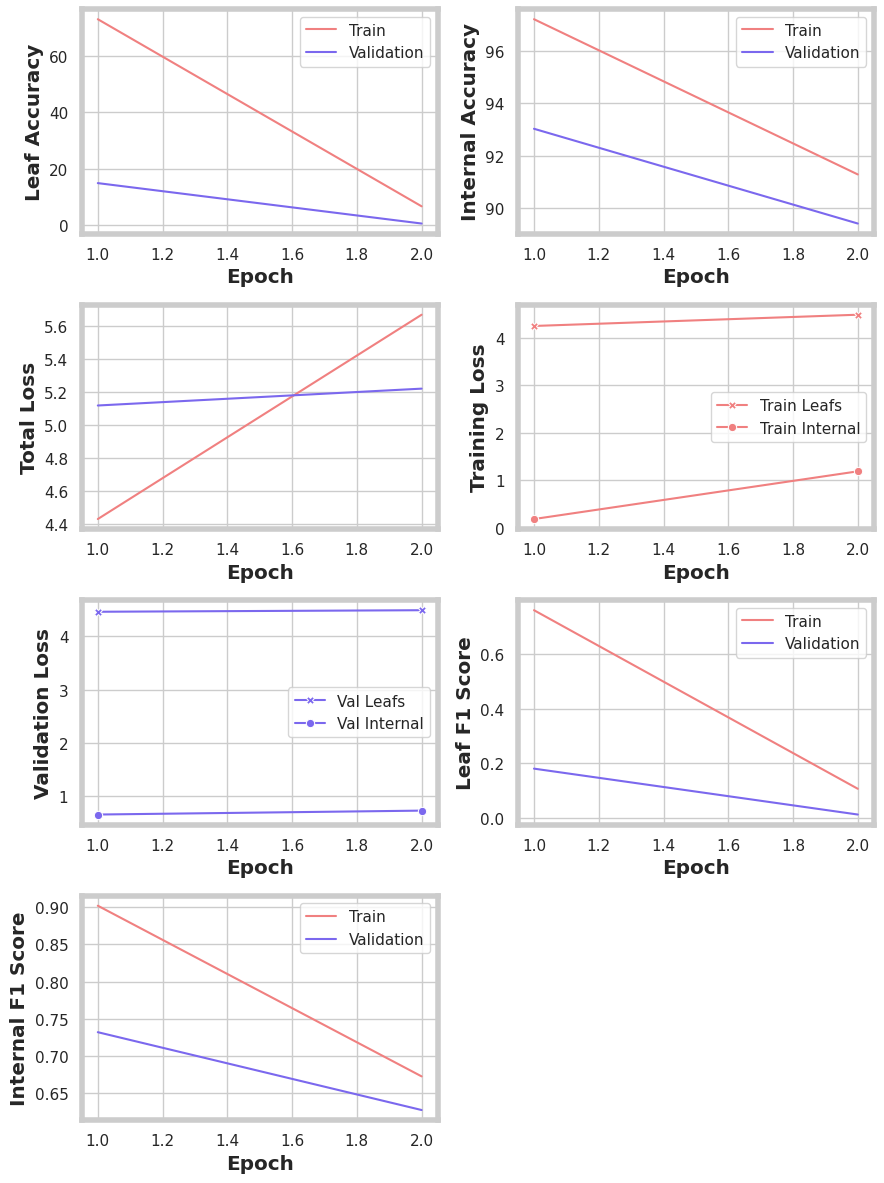

In [25]:
plot_title = today + '_results.png'

# if you want to save the plot
plot_results(marginalization_dict,num_epochs,save_title=plot_title)

# just display the plot
#plot_results(marginalization_dict,num_epochs)



In [51]:
mapping

{'CL:0000037': 0,
 'CL:0000038': 1,
 'CL:0000049': 2,
 'CL:0000050': 3,
 'CL:0000051': 4,
 'CL:0000081': 5,
 'CL:0000084': 6,
 'CL:0000091': 7,
 'CL:0000092': 8,
 'CL:0000094': 9,
 'CL:0000097': 10,
 'CL:0000129': 11,
 'CL:0000232': 12,
 'CL:0000233': 13,
 'CL:0000235': 14,
 'CL:0000236': 15,
 'CL:0000451': 16,
 'CL:0000453': 17,
 'CL:0000492': 18,
 'CL:0000542': 19,
 'CL:0000547': 20,
 'CL:0000556': 21,
 'CL:0000557': 22,
 'CL:0000559': 23,
 'CL:0000576': 24,
 'CL:0000583': 25,
 'CL:0000595': 26,
 'CL:0000623': 27,
 'CL:0000624': 28,
 'CL:0000625': 29,
 'CL:0000738': 30,
 'CL:0000763': 31,
 'CL:0000764': 32,
 'CL:0000765': 33,
 'CL:0000766': 34,
 'CL:0000767': 35,
 'CL:0000771': 36,
 'CL:0000775': 37,
 'CL:0000776': 38,
 'CL:0000782': 39,
 'CL:0000784': 40,
 'CL:0000785': 41,
 'CL:0000786': 42,
 'CL:0000787': 43,
 'CL:0000788': 44,
 'CL:0000789': 45,
 'CL:0000791': 46,
 'CL:0000794': 47,
 'CL:0000798': 48,
 'CL:0000800': 49,
 'CL:0000807': 50,
 'CL:0000808': 51,
 'CL:0000809': 52,
 'C

In [52]:
mapping_dict

{'CL:0000763': -9999,
 'CL:0000542': -9998,
 'CL:0000097': 0,
 'CL:0002046': 1,
 'CL:0000817': 2,
 'CL:0000051': 3,
 'CL:0000826': -9997,
 'CL:0001029': 4,
 'CL:0000990': -9996,
 'CL:0000785': -9995,
 'CL:0000816': 5,
 'CL:0000786': -9994,
 'CL:0000784': -9993,
 'CL:0000557': 6,
 'CL:0000084': -9992,
 'CL:0000814': -9991,
 'CL:0000837': -9990,
 'CL:0000037': 7,
 'CL:0000576': -9989,
 'CL:0000050': 8,
 'CL:0000129': 9,
 'CL:0000815': -9988,
 'CL:0000912': 10,
 'CL:0000940': 11,
 'CL:0000623': -9987,
 'CL:0000899': 12,
 'CL:0000798': -9986,
 'CL:0000235': -9985,
 'CL:0000775': -9984,
 'CL:0000236': -9983,
 'CL:0000453': 13,
 'CL:0002343': 14,
 'CL:0001078': 15,
 'CL:3000001': 16,
 'CL:0000451': -9982,
 'CL:0000094': -9981,
 'CL:0000738': -9980,
 'CL:0000878': -9979,
 'CL:0000972': -9978,
 'CL:0000788': 17,
 'CL:0000985': 18,
 'CL:0000987': 19,
 'CL:0000970': 20,
 'CL:0000913': 21,
 'CL:0000492': -9977,
 'CL:0000624': -9976,
 'CL:0000909': -9975,
 'CL:0000896': -9974,
 'CL:0000906': -9973

In [54]:
encoding_mapper

{-9999: 31,
 -9998: 19,
 0: 10,
 1: 124,
 2: 59,
 3: 4,
 -9997: 62,
 4: 107,
 -9996: 106,
 -9995: 41,
 5: 58,
 -9994: 42,
 -9993: 40,
 6: 22,
 -9992: 6,
 -9991: 56,
 -9990: 64,
 7: 0,
 -9989: 24,
 8: 3,
 9: 11,
 -9988: 57,
 10: 91,
 11: 99,
 -9987: 27,
 12: 81,
 -9986: 48,
 -9985: 14,
 -9984: 37,
 -9983: 15,
 13: 17,
 14: 127,
 15: 119,
 16: 142,
 -9982: 16,
 -9981: 9,
 -9980: 30,
 -9979: 73,
 -9978: 101,
 17: 44,
 18: 104,
 19: 105,
 20: 100,
 21: 92,
 -9977: 18,
 -9976: 28,
 -9975: 89,
 -9974: 78,
 -9973: 86,
 22: 85,
 23: 74,
 -9972: 69,
 -9971: 72,
 -9970: 39,
 24: 71,
 25: 35,
 26: 25,
 -9969: 29,
 -9968: 70,
 -9967: 140,
 27: 133,
 -9966: 118,
 -9965: 34,
 28: 33,
 -9964: 137,
 -9963: 80,
 -9962: 117,
 29: 83,
 -9961: 43,
 -9960: 55,
 -9959: 12,
 30: 90,
 -9958: 65,
 -9957: 66,
 31: 1,
 32: 20,
 33: 128,
 34: 123,
 35: 23,
 -9956: 112,
 36: 63,
 37: 21,
 38: 8,
 39: 97,
 40: 96,
 41: 2,
 42: 36,
 -9955: 134,
 -9954: 120,
 -9953: 136,
 43: 52,
 44: 135,
 45: 93,
 -9952: 79,
 -9951

In [48]:
cell_type_encoder.classes_

array(['CL:0000037', 'CL:0000038', 'CL:0000049', 'CL:0000050',
       'CL:0000051', 'CL:0000081', 'CL:0000084', 'CL:0000091',
       'CL:0000092', 'CL:0000094', 'CL:0000097', 'CL:0000129',
       'CL:0000232', 'CL:0000233', 'CL:0000235', 'CL:0000236',
       'CL:0000451', 'CL:0000453', 'CL:0000492', 'CL:0000542',
       'CL:0000547', 'CL:0000556', 'CL:0000557', 'CL:0000559',
       'CL:0000576', 'CL:0000583', 'CL:0000595', 'CL:0000623',
       'CL:0000624', 'CL:0000625', 'CL:0000738', 'CL:0000763',
       'CL:0000764', 'CL:0000765', 'CL:0000766', 'CL:0000767',
       'CL:0000771', 'CL:0000775', 'CL:0000776', 'CL:0000782',
       'CL:0000784', 'CL:0000785', 'CL:0000786', 'CL:0000787',
       'CL:0000788', 'CL:0000789', 'CL:0000791', 'CL:0000794',
       'CL:0000798', 'CL:0000800', 'CL:0000807', 'CL:0000808',
       'CL:0000809', 'CL:0000810', 'CL:0000811', 'CL:0000813',
       'CL:0000814', 'CL:0000815', 'CL:0000816', 'CL:0000817',
       'CL:0000818', 'CL:0000823', 'CL:0000826', 'CL:00

In [49]:
help(cell_type_encoder)

Help on LabelEncoder in module sklearn.preprocessing._label object:

class LabelEncoder(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  Encode target labels with value between 0 and n_classes-1.
 |  
 |  This transformer should be used to encode target values, *i.e.* `y`, and
 |  not the input `X`.
 |  
 |  Read more in the :ref:`User Guide <preprocessing_targets>`.
 |  
 |  .. versionadded:: 0.12
 |  
 |  Attributes
 |  ----------
 |  classes_ : ndarray of shape (n_classes,)
 |      Holds the label for each class.
 |  
 |  See Also
 |  --------
 |  OrdinalEncoder : Encode categorical features using an ordinal encoding
 |      scheme.
 |  OneHotEncoder : Encode categorical features as a one-hot numeric array.
 |  
 |  Examples
 |  --------
 |  `LabelEncoder` can be used to normalize labels.
 |  
 |  >>> from sklearn import preprocessing
 |  >>> le = preprocessing.LabelEncoder()
 |  >>> le.fit([1, 2, 2, 6])
 |  LabelEncoder()
 |  >>> le.classes_
 |  array([1, 2, 6])
 |  >